In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
from matplotlib import cm # Colormaps
# import matplotlib.colors as colors
import matplotlib.dates as mdates

fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

# from datetime import date
import datetime as dt

# import locale
# locale.setlocale(locale.LC_TIME,"Danish")
# locale.setlocale(locale.LC_ALL,"Danish")


In [2]:
# np.datetime64('2021-03-29')

In [3]:
def test_correct(actual_cases, actual_tests, pr_num_tests):
    return actual_cases*(pr_num_tests/actual_tests)**0.7

In [58]:
def hosp_case_rate(hosp, case, screen):
    return hosp/(case - screen)

def screen(c1, c2):
    hosp1, case1, screen1 = c1
    #print(c1)
    #print(c2)
    #print(case1 - hosp1/hosp_case_rate(*c2))
    return case1 - hosp1/hosp_case_rate(*c2)

Antag at forskelle i tilsyneladende indlæggelsesrate 
(indlæggelse pr. case) alene skyldes forskelle i mørketal. 
Cases fundet udover dem, der skal til for at give samme 
indlæggelsesrate som Norge (?) må da skyldes øget testning.

In [59]:
df_tests = pd.read_csv("data/data_tests.csv")

dow = 7

df_cases= pd.read_csv("data/data_cases.csv")
df_cases["dateRep"] = pd.to_datetime(df_cases["dateRep"], format='%d/%m/%Y')
df_cases.rename(columns = {'dateRep':'date'}, inplace = True)
df_cases["year_week"] = [str(x) + "-W" + str(y) for x,y in zip(df_cases["year"], df_cases["date"].dt.week)]
df_cases["weekdate"] = [dt.datetime.strptime(d + '-' + str(dow), '%G-W%V-%u') for d in df_cases["year_week"]]

df_hosp = pd.read_csv("data/data_hosp.csv")
df_hosp["weekdate"] = [dt.datetime.strptime(d + '-' + str(dow), '%G-W%V-%u') for d in df_hosp["year_week"]]


df_hosp.loc[df_hosp.country == "Sweden", "indicator"].unique()

array(['Daily hospital occupancy', 'Daily ICU occupancy',
       'Weekly new ICU admissions per 100k'], dtype=object)

In [60]:
def hospitalizations(country):
    hosp = df_hosp.loc[df_hosp.country == country]
    # print(hosp)
    pop_105 = df_cases.loc[df_cases.countriesAndTerritories == country, "popData2020"].unique()[0]/(1e5)
    selection = (hosp["indicator"] == "Weekly new hospital admissions per 100k")
    #print(hosp.loc[selection])
    plotdata = pd.DataFrame(hosp.loc[selection].groupby(["weekdate"])["value"].sum().reset_index())
    plotdata.value = plotdata.value*pop_105
    return plotdata

def cases(country):
    cases = df_cases.loc[df_cases.countriesAndTerritories == country]
    selection = (df_cases.weekdate > "2021-03-07")
    plotdata = pd.DataFrame(cases.loc[selection].groupby(["weekdate"])["cases"].sum().reset_index())
    plotdata.rename(columns = {'cases':'value'}, inplace = True)
    return plotdata

def common_dates(dates1, dates2):
    return sorted(list(set(dates1).intersection(set(dates2))))


(18688.0, 18798.0)

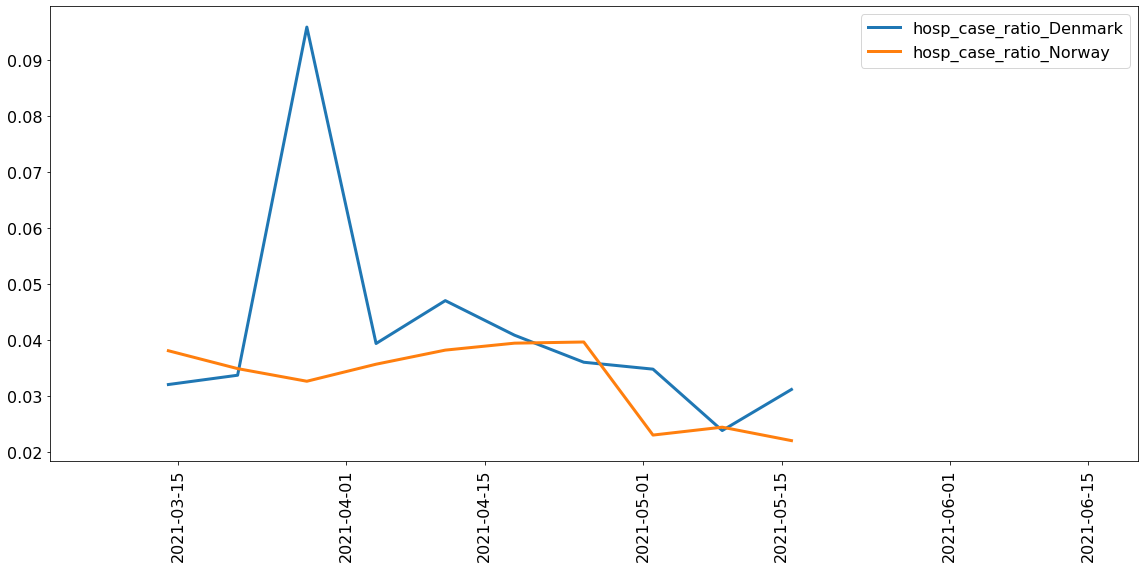

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(16,8), tight_layout=True)

ctrys = ["Denmark", "Norway"]

#plotdata = hospitalizations(c)
#ax.plot(plotdata.weekdate, plotdata.value, label="hospitalizations_" + c)
#print(plotdata.weekdate)

#plotdata = cases(c)
#ax.plot(plotdata.weekdate, plotdata.value, label="cases_" + c)
#print(plotdata.weekdate)

sig_dict = {}
plot_days = []

for c in ctrys:
    plot_days = common_dates(cases(c).weekdate, hospitalizations(c).weekdate)
    hosp = hospitalizations(c).loc[hospitalizations(c).weekdate.isin(plot_days), "value"]
    case = cases(c).loc[cases(c).weekdate.isin(plot_days), "value"]

    sig_dict[c] = [hosp.values, case.values, 0] 
    
    ax.plot(plot_days, hosp.values/case.values, label="hosp_case_ratio_" + c)

#ax.plot(plot_days, screen(sig_dict["Denmark"], sig_dict["Norway"]), label="screening")

ax.legend()

plt.xticks(rotation=90)
plt.xlim("2021-03-02", "2021-06-20")

